# Forschungspraktikum SS20 
# Semantic Differentials for Wikipedia using the POLAR Framework


The POLAR Framework is a method that enables Interpretability for pre-trained word embeddings. The goal of this project is to produce word embeddings from a Wikipedia dataset, and deploy the POLAR framework to different categories of words (e.g. Countries, Politicians, Music, etc) in order to explain the semantic associations behind concepts on Wikipedia. An evaluation setup should assess the quality of the semantic differentials produced.

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import multiprocessing
from gensim.corpora.wikicorpus import WikiCorpus #https://radimrehurek.com/gensim/corpora/wikicorpus.html
from gensim.models.word2vec import Word2Vec

# Only run next cell if a new Wikipedia dataset is loaded

In [15]:
trainNewModel=False
loadNewDataset= False

In [16]:
if trainNewModel==True:
    wiki = WikiCorpus('/Users/Jan/Desktop/Uni/CoronaSemester/Praktikum/DataSets/enwiki-20200401-pages-articles1.xml-p1p30303.bz2', 
                  lemmatize=False, dictionary={})
    #stores the preprocessed dataset, which reduces runtime for the future
    wiki.save('SavedWord2Vec/wiki.corpus')
    
    sentences = list(wiki.get_texts()) #Iterate over the dump, yielding a list of tokens for each article that passed the length and namespace filtering.



size: The number of dimensions of the embeddings and the default is 100.

window: The maximum distance between a target word and words around the target word. The default window is 5.

min_count: The minimum count of words to consider when training the model; words with occurrence less than this 
count will be ignored. The default for min_count is 5.

workers: The number of partitions during training and the default workers is 3.

sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

In [18]:
### Compute the Word2Vec model usint following parameters#
# Currently using CBOW for testing because of performance issues of skip gram on my laptop #
if trainNewModel==True:
    print("Training Word2Vec model ...")
    params = {'size': 300, 'window': 5, 'min_count': 5, 
          'workers': max(1, multiprocessing.cpu_count() - 1), 'sample': 1E-3,'sg' : 1}
    word2vec = Word2Vec(sentences, **params)
    ### Save Word2Vec model to file ###
    word2vec.save('SavedWord2Vec/wiki.word2vec.model')
    print("Finished Training")
else:
    ### Loading finished Word2Vec model to memory from file ###
    print("Loading Word2Vec model from file...")
    word2vec = Word2Vec.load('SavedWord2Vec/wiki.word2vec.model')
    print("Finished Loading")


Loading Word2Vec model from file...
Finished Loading


In [6]:
female_king = word2vec.most_similar_cosmul(positive='donald'.split(), 
                                           negative='mtu'.split(), topn=5,)
for ii, (word, score) in enumerate(female_king):
    print("{}. {} ({:1.2f})".format(ii+1, word, score))


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  


1. jester (1.94)
2. griffin (1.93)
3. barry (1.93)
4. ridiculous (1.93)
5. scandalous (1.93)


In [43]:
def similarityNameVector(vec, name):
    
    cosineSimilarity = np.dot(vec, word2vec[name])/(np.linalg.norm(vec)* np.linalg.norm(word2vec[name]))
    return cosineSimilarity

print(similarityWordVector(ourQueen,'queen'))



0.6740092


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
print("Smiliarity of king and queen:", word2vec.wv.similarity('king', 'queen'))
ourQueen= word2vec['king'] - word2vec['man'] + word2vec['woman']
print("Smiliarity of transformed king and queen:", similarityWordVector(ourQueen,'queen'))

word2vec.most_similar(positive=[ourQueen], topn=10)




Smiliarity of king and queen: 0.59889406
Smiliarity of transformed king and queen: 0.6740092


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """


[('king', 0.7742398977279663),
 ('queen', 0.6740092039108276),
 ('isabella', 0.6124592423439026),
 ('empress', 0.5961050987243652),
 ('jadwiga', 0.5852029323577881),
 ('consort', 0.5839527249336243),
 ('regent', 0.5740820169448853),
 ('matilda', 0.5739670395851135),
 ('throne', 0.5544346570968628),
 ('countess', 0.5541669130325317)]

In [175]:
print(word2vec.wv.similarity('germany', 'europe')) 
print(word2vec.wv.similarity('leyen', 'europe'))

0.5666904
-0.08363264


However, Euclidian similarity cannot work well for the high-dimensional word vectors.
This is because Euclidian similarity will increase as the number of dimensions increases, even if the word embedding stands for different meanings.
Alternatively, we can use cosine similarity to measure the similarity between two vectors.
Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The cosine similarity captures the angle of the word vectors and not the magnitude. Under cosine similarity, no similarity is expressed as a 90-degree angle while the total similarity of 1 is at a 0-degree angle.

In [158]:
word2vec.similarity('star', 'hollywood')  
#'köln', 'akademie'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.3782852

In [47]:
word2vec.most_similar('afghanistan')[:20]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('afghan', 0.79572993516922),
 ('pakistan', 0.7452889680862427),
 ('taliban', 0.7253729104995728),
 ('kabul', 0.7165947556495667),
 ('iraq', 0.7116062641143799),
 ('iran', 0.6943484544754028),
 ('kandahar', 0.6912568211555481),
 ('mujahideen', 0.6624311208724976),
 ('tajikistan', 0.654268741607666),
 ('sharif', 0.6537976264953613)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


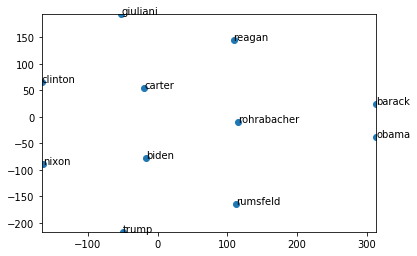

In [9]:
from sklearn.manifold import TSNE
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.similar_by_word(word)
    #print(arr)
    #print(np.array([model[word]]))
    arr = np.append(arr, np.array([model[word]]), axis=0)
    
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

    
display_closestwords_tsnescatterplot(model, 'trump', 200) 

In [8]:
model = word2vec

# Online training / Resuming training

Advanced users can load a model and continue training it with more sentences and new vocabulary words:

model = gensim.models.Word2Vec.load(temporary_filepath)
more_sentences = [
    ['Advanced', 'users', 'can', 'load', 'a', 'model',
     'and', 'continue', 'training', 'it', 'with', 'more', 'sentences']
]
model.build_vocab(more_sentences, update=True)
model.train(more_sentences, total_examples=model.corpus_count, epochs=model.iter)

cleaning up temporary file
import os
os.remove(temporary_filepath)